In [1]:
!python -m spacy download en_core_web_lg

2023-08-30 18:28:53.917773: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 18:28:55.680271: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [2]:
!pip install tomotopy
!pip install tmplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.4 MB/s eta 0:00:00


In [3]:
# load libraries
import os
import re
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import spacy
import tomotopy as tp
import tmplot as tmp
from rich.console import Console
from rich.table import Table

In [4]:
# Read corpus
#from google.colab import drive
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/FinalFiat.csv"
df = pd.read_csv(file_path)


Mounted at /content/drive


In [5]:
df.head()

,comments,year,month,day
0,How to make this review short. Fiat have a Win...,2021,4,24
1,"Nice review, I am having a test drive on Tuesd...",2021,4,24
2,I saw Jonny Smith’s early review of this and t...,2021,4,24
3,I work in the NHS and with their finance packa...,2021,4,24
4,I noticed this site seems to have some really ...,2021,4,24


In [6]:
df.shape

(10162, 4)

In [7]:
# Define the list of desired words
Fiat_e_words = ['Fiat500e', 'Fiat 500e', 'fiat500e', 'fiat 500e' , '500e', '500 e']

# Convert the desired words list to lowercase
Fiat_e_lower = [word.lower() for word in Fiat_e_words]

# Create a regular expression pattern to match any of the desired words
pattern = re.compile('|'.join(Fiat_e_words), re.IGNORECASE)


In [8]:
# Filter the rows based on the desired words in the "comments" column
Fiat_e = df[df['comments'].str.contains('|'.join(Fiat_e_words))]

In [9]:
Fiat_e

,comments,year,month,day
13,What's the delivery lead time on the 500e? Wha...,2021,4,27
15,Looks like the 500e is doing the rounds of all...,2021,5,21
16,Although the CEO of Fiat says he is losing mon...,2015,3,18
17,It's great to live in California... \n \nYou ...,2015,3,18
18,"Never been to California, but I'd like to. If ...",2015,3,18
...,...,...,...,...
9604,RT @jonoread: Alan going through his Fiat 500 ...,2023,6,8
9606,RT @jonoread: Alan going through his Fiat 500 ...,2023,6,8
9625,RT @jonoread: Alan going through his Fiat 500 ...,2023,6,8
9626,RT @jonoread: Alan going through his Fiat 500 ...,2023,6,8


In [10]:
# Initialize a pipeline
nlp = spacy.load("en_core_web_lg")

In [11]:
# Define a list of unwanted words
unwanted_words = ['rt', 'crypto', 'bitcoin', 'blockchain', 'patex', 'currency', 'patex_ecosystem','twitter','ve','tweet', 'retweet', '@', 'http']  # Add your unwanted words to this list

# Process data and store all lemmas
docs_tokens, all_lemmas = [], []
for item in Fiat_e.loc[:, "comments"].astype(str).to_list():
    # Use regular expression to remove special characters, URLs, and non-alphanumeric characters
    item = re.sub(r'https?://\S+|www\.\S+', '', item)  # Remove URLs
    item = re.sub(r'[^\w\s]', ' ', item)  # Remove non-alphanumeric characters (except for spaces)
    item = re.sub(r'\s+', ' ', item).strip()  # Remove extra spaces and leading/trailing spaces
    item = re.sub(r'\n', ' ', item)  # Remove newline characters
    item = re.sub(r'\t', ' ', item)  # Remove tab characters
    item = re.sub(r'#', '', item)    # Remove pound sign

    # Convert all words to lowercase
    item = item.lower()

    tmp_tokens = [
        token.lemma_
        for token in nlp(item)
        if (
            not token.is_stop
            and not token.is_punct
            and not token.like_num
            and not token.is_space
            and len(token.text) > 1  # Remove single characters and very short words
        )
    ]

    # Remove unwanted words
    tmp_tokens = [word for word in tmp_tokens if word not in unwanted_words]

    # Check if the document is not empty after removing unwanted words
    if tmp_tokens:
        docs_tokens.append(tmp_tokens)
        all_lemmas.extend(tmp_tokens)

In [12]:
# Tomotopy LDA estimation
corpus = tp.utils.Corpus()
for item in docs_tokens:
    corpus.add_doc(words=item)

lda = tp.LDAModel(min_df=5, rm_top=10, k=10, corpus=corpus, seed=333)

# Train the model
for i in range(0, 1000, 10):
    lda.train(10)
    print("Iteration: {}\tLog-likelihood: {}".format(i, lda.ll_per_word))

<ipython-input-12-8e0dc416ff61>:10: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  lda.train(10)


Iteration: 0	Log-likelihood: -6.708367191900418
Iteration: 10	Log-likelihood: -6.512009130672255
Iteration: 20	Log-likelihood: -6.421846645472684
Iteration: 30	Log-likelihood: -6.391046219533584
Iteration: 40	Log-likelihood: -6.356386011804708
Iteration: 50	Log-likelihood: -6.34453194100103
Iteration: 60	Log-likelihood: -6.314934243983903
Iteration: 70	Log-likelihood: -6.3086139939444
Iteration: 80	Log-likelihood: -6.317159957546394
Iteration: 90	Log-likelihood: -6.310620060192796
Iteration: 100	Log-likelihood: -6.312919058358098
Iteration: 110	Log-likelihood: -6.296071834085653
Iteration: 120	Log-likelihood: -6.2949061628600615
Iteration: 130	Log-likelihood: -6.280393821867321
Iteration: 140	Log-likelihood: -6.285342501453289
Iteration: 150	Log-likelihood: -6.295128162483436
Iteration: 160	Log-likelihood: -6.269753294885676
Iteration: 170	Log-likelihood: -6.292919957234483
Iteration: 180	Log-likelihood: -6.285124596258548
Iteration: 190	Log-likelihood: -6.283358873106141
Iteration: 20

In [13]:
phi = tmp.get_phi(lda)
phi

topics,0,1,2,3,4,5,6,7,8,9
words,,,,,,,,,,
new,0.057816,0.000014,0.000009,0.000012,0.000010,0.000018,0.000028,0.000027,0.000013,0.000019
go,0.035692,0.040116,0.000009,0.000012,0.000010,0.000018,0.000028,0.000027,0.000013,0.000019
range,0.000007,0.011076,0.048966,0.019379,0.000010,0.000018,0.000028,0.000027,0.000013,0.000019
year,0.040688,0.000014,0.000009,0.000012,0.000010,0.000018,0.000028,0.000027,0.000013,0.030029
think,0.029982,0.013842,0.008483,0.000012,0.000010,0.000018,0.000028,0.000027,0.000013,0.018775
...,...,...,...,...,...,...,...,...,...,...
aren,0.000007,0.000014,0.000009,0.000012,0.000010,0.000018,0.000028,0.000027,0.006591,0.000019
speak,0.000007,0.000014,0.000009,0.000012,0.000010,0.000018,0.000028,0.000027,0.006591,0.000019
sort,0.000007,0.000014,0.000009,0.000012,0.000010,0.000018,0.000028,0.000027,0.006591,0.000019


In [14]:
tmp.get_top_docs(corpus, model=lda)

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,"(hi, ophone, lucembourg, way, central, italy, ...","(post, fiat, forum, info, problemsjuat, think,...","(memory, miss, phase, ac, capable, evs, sell, ...","(trialle, charging, include, subscription, tie...","(500e, driver, issue, intelligent, speed, assi...","(hey, order, fiat, 500e, icon, afford, home, w...","(elmo, offer, subscription, car, include, depo...","(day, ago, deep, bev, deep, plug, in, count, f...","(car, current, 500e, carb, special, fiat, clai...","(enjoy, drive, little, fiat, 500e, california,..."
1,"(hopefully, mercede, start, compete, formula, ...","(post, fiat, forum, info, problemsjuat, think,...","(yes, drive, 42kwh, version, wife, car, fit, h...","(trialle, charging, include, subscription, tie...","(500e, driver, issue, intelligent, speed, assi...","(hey, order, fiat, 500e, icon, afford, home, w...","(elmo, go, to, offer, fiat, 500e, la, prima, 4...","(day, ago, deep, bev, deep, plug, in, count, f...","(car, current, 500e, carb, special, fiat, clai...","(enjoy, drive, little, fiat, 500e, california,..."
2,"(hi, ophone, lucembourg, way, central, italy, ...","(hi, 500e, icon, lease, go, good, untill, mont...","(budget, handful, small, evs, size, class, fab...","(dort, 500e, month, energy, work, kwh, mile, c...","(dealer, electrical, issue, get, permission, f...","(500e, go, sale, imminently, uk, new, version,...","(disclaimer, post, identical, post, kia, niro,...","(ll, disqualify, contest, follow, picture, day...","(fiat500, massively, popular, europe, chance, ...","(enjoy, drive, little, fiat, 500e, california,..."
3,"(hopefully, mercede, start, compete, formula, ...","(fiat, 500e, cupra, bear, ev, road, trip, scot...","(yes, drive, 42kwh, version, wife, car, fit, h...","(fiat, 500e, red, sustained, body, damage, dec...","(dealer, electrical, issue, get, permission, f...","(thank, helpful, wallbox, come, box, boot, car...","(elmo, go, to, offer, fiat, 500e, la, prima, 4...","(jonoread, alan, go, fiat, era, xx)","(fiat500, massively, popular, europe, chance, ...","(enjoy, drive, little, fiat, 500e, california,..."
4,"(fiat, 500e, depth, owner, review, small, ev, ...","(500e, icon, yea, old, completely, fine, issue...","(problem, city, car, typically, don, offer, ne...","(dort, 500e, month, energy, work, kwh, mile, c...","(new, 500e, week, expect, steering, light, esp...","(wasn, aware, lock, sync, charger, surprised, ...","(disclaimer, post, identical, post, hyundai, k...","(jonoread, alan, go, fiat, era, xx)","(unfortunate, access, level, charge, great, li...","(hmm, kwh, mile, search, ev, database, uk, ran..."


In [15]:
top_docs_topic3 = tmp.get_top_docs(corpus, model=lda, docs_num=10, topics=[3])
top_docs_topic3

,topic3
0,"(trialle, charging, include, subscription, tie..."
1,"(trialle, charging, include, subscription, tie..."
2,"(dort, 500e, month, energy, work, kwh, mile, c..."
3,"(fiat, 500e, red, sustained, body, damage, dec..."
4,"(dort, 500e, month, energy, work, kwh, mile, c..."
5,"(weight, size, pollution, potential, oh, noise..."
6,"(fiat, 500e, noise, test)"
7,"(neighbour, informal, arrangement, friend, sha..."
8,"(california, like, try, 500e, time)"
9,"(california, like, try, 500e, time)"


In [16]:
# Calculate the degree distribution of removed words
lemmas, counts = np.unique(all_lemmas, return_counts=True)
degree_distribution = pd.DataFrame({'Lemma': lemmas, 'Frequency': counts})

In [17]:
# Sort the degree distribution by word frequencies
degree_distribution = degree_distribution.sort_values(by='Frequency', ascending=False)

In [18]:
# Get top 10 lemmas and their corresponding frequencies
top_lemmas = degree_distribution.iloc[:10]['Lemma']
top_frequencies = degree_distribution.iloc[:10]['Frequency']

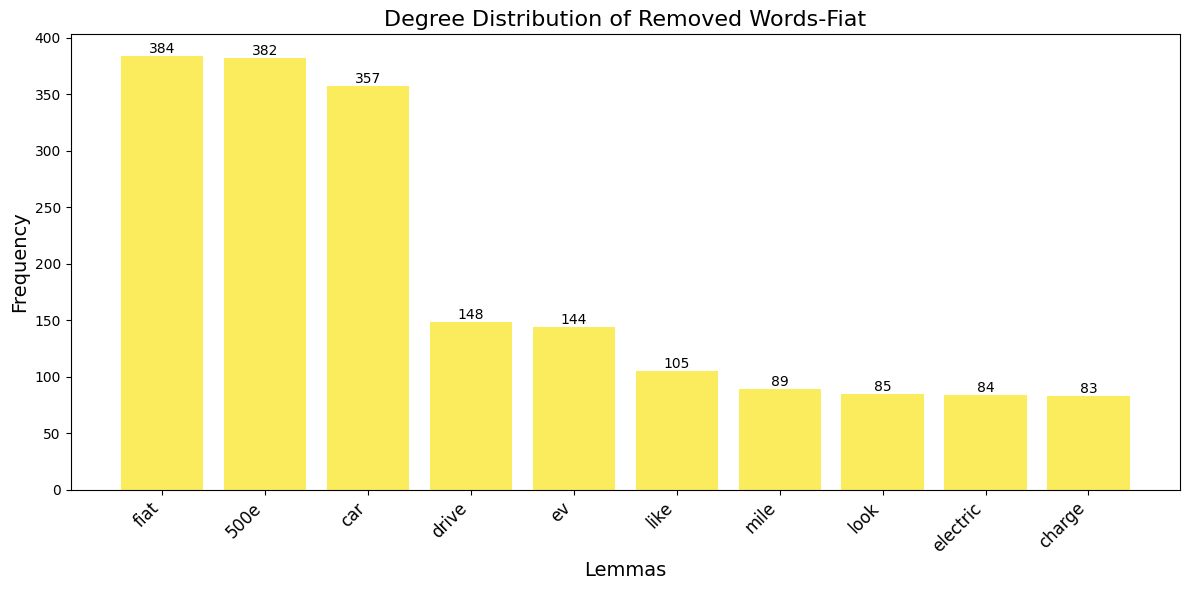

In [19]:
# Visualize the degree distribution
plt.figure(figsize=(12, 6))
plt.bar(top_lemmas, top_frequencies, color='#FBEC5D')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.xlabel('Lemmas', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Degree Distribution of Removed Words-Fiat', fontsize=16)
plt.tight_layout()

# Add labels to the bars
for i, freq in enumerate(top_frequencies):
    plt.text(i, freq, str(freq), ha='center', va='bottom')

plt.show()

In [20]:
# inspect the output of the LDA algorithm

# Print the topics with the words inside each topic
for k in range(lda.k):
    topic_words = [word for word, prob in lda.get_topic_words(k)]
    print(f"Topic #{k}: {', '.join(topic_words)}")

Topic #0: new, year, good, go, battery, think, way, come, ll, old
Topic #1: trip, long, go, say, get, warning, start, boot, work, week
Topic #2: tesla, range, zoe, model, version, honda, mini, wife, well, probably
Topic #3: month, time, need, want, try, don, work, road, petrol, day
Topic #4: get, issue, thing, app, test, dealer, currently, see, speed, help
Topic #5: charger, home, cable, order, use, main, sure, rapid, come, price
Topic #6: vehicle, la, kia, prima, hyundai, kona, town, niro, convertible, lead
Topic #7: ford, leaf, model, plug, fun, california, hybrid, vehicle, focus, volt
Topic #8: buy, sell, market, level, price, offer, people, know, company, don
Topic #9: uk, kwh, cost, california, standard, ship, model, year, brake, expensive


In [21]:
Theme_Fiat_E=["charging availability",
              "EV's car comparison",
              "Electric Vehicle Model Showcase",
              "Costs and Pricing EVs",
              "EV User Experience & Challenges",
              "Dealer Interaction",
              "Tesla and Other EV Models",
              "Comparing EV Efficiency and Range",
              "EV Market Trends & Insights",
              "Exploring EV Market Trends and Costs"]

In [22]:
# Prepare topic coordinates
topics_coords = tmp.prepare_coords(lda)

# Sort topics_coords by topic in descending order
topics_coords = topics_coords.sort_values(by='size', ascending=False)

topics_coords

,x,y,topic,size,label
0,42.524044,23.903503,0,20.978912,0
2,-87.117348,-16.032084,2,13.872326,2
4,-30.228016,39.828690,4,13.795100,4
3,-31.127274,-60.856434,3,11.468549,3
8,82.896790,-41.210228,8,10.300592,8
1,-3.261580,12.352264,1,7.365853,1
5,52.129852,68.002930,5,6.412850,5
9,59.493595,-7.702054,9,6.212571,9
7,-55.795685,-27.114597,7,5.098741,7
6,4.391800,68.092278,6,4.494508,6


In [23]:
data=topics_coords

In [24]:
# Save the DataFrame as a CSV file in Google Drive
data.to_csv("drive/My Drive/topics_coords_fiat500.csv")

In [25]:
tmp.report(lda, docs=corpus, height=500, width=250)

In [26]:
# Get the topic distribution for each document
topic_distributions = [doc.get_topic_dist() for doc in lda.docs]

# Create a DataFrame to store the distribution of each topic for each document
topic_distribution_df = pd.DataFrame(topic_distributions)

# Add the original comments as a new column in the DataFrame
topic_distribution_df["Comments"] = df["comments"]

csv_file_path = '/content/drive/My Drive/Colab Notebooks/topic_distribution_fiat_.csv'
topic_distribution_df.to_csv(csv_file_path, index=False)

In [27]:
# inspect the output of the LDA algorithm

# create a Rich's table to print the output of the spaCy's pipeline
console = Console()
# defin table properties
table = Table(
    show_header=True,
    header_style="cyan",
    title="[bold] [cyan] Word to topic probabilities (top 10 words)[/cyan]",
    width=150,
)
# add columns
table.add_column("Topic", justify="center", style="cyan", width=10)
table.add_column("W 1", width=12)
table.add_column("W 2", width=12)
table.add_column("W 3", width=12)
table.add_column("W 4", width=12)
table.add_column("W 5", width=12)
table.add_column("W 6", width=12)
table.add_column("W 7", width=12)
table.add_column("W 8", width=12)
table.add_column("W 9", width=12)
table.add_column("W 10", width=12)
# add rows
for k in range(lda.k):
    values = []
    for word, prob in lda.get_topic_words(k):
        values.append("{}\n({})\n".format(word, str(np.round(prob, 3))))
    table.add_row(
        str(k),
        values[0],
        values[1],
        values[2],
        values[3],
        values[4],
        values[5],
        values[6],
        values[7],
        values[8],
        values[9],
    )
# print the table
table

                                                       Word to topic probabilities (top 10 words)                                                     
┏━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃   Topic   ┃ W 1         ┃ W 2         ┃ W 3         ┃ W 4         ┃ W 5        ┃ W 6         ┃ W 7        ┃ W 8         ┃ W 9        ┃ W 10        ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│     0     │ new         │ year        │ good        │ go          │ battery    │ think       │ way        │ come        │ ll         │ old         │
│           │ (0.058)     │ (0.041)     │ (0.038)     │ (0.036)     │ (0.034)    │ (0.03)      │ (0.027)    │ (0.026)     │ (0.025)    │ (0.024)     │
│           │             │             │             │             │            │             │            │             │            │             │
│     1     │ trip        │ long        │ go          │ say         │ get        │ warning     │ start      │ boot        │ work       │ week        │
│           │ (0.044)     │ (0.043)     │ (0.04)      │ (0.037)     │ (0.033)    │ (0.028)     │ (0.026)    │ (0.025)     │ (0.025)    │ (0.024)     │
│           │             │             │             │             │            │             │            │             │            │             │
│     2     │ tesla       │ range       │ zoe         │ model       │ version    │ honda       │ mini       │ wife        │ well       │ probably    │
│           │ (0.056)     │ (0.049)     │ (0.035)     │ (0.027)     │ (0.025)    │ (0.024)     │ (0.024)    │ (0.023)     │ (0.023)    │ (0.023)     │
│           │             │             │             │             │            │             │            │             │            │             │
│     3     │ month       │ time        │ need        │ want        │ try        │ don         │ work       │ road        │ petrol     │ day         │
│           │ (0.063)     │ (0.063)     │ (0.058)     │ (0.044)     │ (0.042)    │ (0.04)      │ (0.03)     │ (0.029)     │ (0.027)    │ (0.025)     │
│           │             │             │             │             │            │             │            │             │            │             │
│     4     │ get         │ issue       │ thing       │ app         │ test       │ dealer      │ currently  │ see         │ speed      │ help        │
│           │ (0.033)     │ (0.031)     │ (0.029)     │ (0.026)     │ (0.024)    │ (0.022)     │ (0.02)     │ (0.02)      │ (0.02)     │ (0.02)      │
│           │             │             │             │             │            │             │            │             │            │             │
│     5     │ charger     │ home        │ cable       │ order       │ use        │ main        │ sure       │ rapid       │ come       │ price       │
│           │ (0.114)     │ (0.048)     │ (0.047)     │ (0.043)     │ (0.041)    │ (0.034)     │ (0.03)     │ (0.029)     │ (0.027)    │ (0.027)     │
│           │             │             │             │             │            │             │            │             │            │             │
│     6     │ vehicle     │ la          │ kia         │ prima       │ hyundai    │ kona        │ town       │ niro        │ convertib… │ lead        │
│           │ (0.062)     │ (0.056)     │ (0.051)     │ (0.051)     │ (0.051)    │ (0.051)     │ (0.045)    │ (0.042)     │ (0.034)    │ (0.031)     │
│           │             │             │             │             │            │             │            │             │            │             │
│     7     │ ford        │ leaf        │ model       │ plug        │ fun        │ california  │ hybrid     │ vehicle     │ focus      │ volt        │
│           │ (0.055)     │ (0.049)     │ (0.044)     │ (0.044)     │ (0.0

In [28]:
# Select the rest of the data by using the ~ operator to negate the filter
Fiat = df[~df['comments'].str.contains('|'.join(Fiat_e_words))]

In [29]:
Fiat

,comments,year,month,day
0,How to make this review short. Fiat have a Win...,2021,4,24
1,"Nice review, I am having a test drive on Tuesd...",2021,4,24
2,I saw Jonny Smith’s early review of this and t...,2021,4,24
3,I work in the NHS and with their finance packa...,2021,4,24
4,I noticed this site seems to have some really ...,2021,4,24
...,...,...,...,...
10157,"2013 Fiat 500 1.2 POP 3Dr, ONLY 33k MILES, Lon...",2023,6,12
10158,"Enter the All-Electric #Fiat500, a space of ch...",2023,6,10
10159,Introducing the #Fiat #eGrant! ⚡️\n\n#Fiat has...,2023,6,6
10160,Introducing the #Fiat #eGrant! ⚡️\n\n#Fiat has...,2023,6,5


In [30]:
# Define a list of unwanted words
unwanted_words = ['rt', 'crypto', 'bitcoin', 'blockchain', 'patex', 'currency', 'patex_ecosystem','twitter','ve','tweet', 'retweet', '@', 'http']  # Add your unwanted words to this list

# Process data and store all lemmas
docs_tokens2, all_lemmas = [], []
for item in Fiat.loc[:, "comments"].astype(str).to_list():
    # Use regular expression to remove special characters, URLs, and non-alphanumeric characters
    item = re.sub(r'https?://\S+|www\.\S+', '', item)  # Remove URLs
    item = re.sub(r'[^\w\s]', ' ', item)  # Remove non-alphanumeric characters (except for spaces)
    item = re.sub(r'\s+', ' ', item).strip()  # Remove extra spaces and leading/trailing spaces
    item = re.sub(r'\n', ' ', item)  # Remove newline characters
    item = re.sub(r'\t', ' ', item)  # Remove tab characters
    item = re.sub(r'#', '', item)    # Remove pound sign

    # Convert all words to lowercase
    item = item.lower()

    tmp_tokens = [
        token.lemma_
        for token in nlp(item)
        if (
            not token.is_stop
            and not token.is_punct
            and not token.like_num
            and not token.is_space
            and len(token.text) > 1  # Remove single characters and very short words
        )
    ]

    # Remove unwanted words
    tmp_tokens = [word for word in tmp_tokens if word not in unwanted_words]

    # Check if the document is not empty after removing unwanted words
    if tmp_tokens:
        docs_tokens2.append(tmp_tokens)
        all_lemmas.extend(tmp_tokens)

In [31]:
# Tomotopy LDA estimation
corpus2 = tp.utils.Corpus()
for item in docs_tokens2:
    corpus2.add_doc(words=item)

lda2 = tp.LDAModel(min_df=5, rm_top=10, k=10, corpus=corpus2, seed=333)

# Train the model
for i in range(0, 1000, 10):
    lda2.train(10)
    print("Iteration: {}\tLog-likelihood: {}".format(i, lda2.ll_per_word))

<ipython-input-31-27a95cd8fbfb>:10: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  lda2.train(10)


Iteration: 0	Log-likelihood: -8.453643389687715
Iteration: 10	Log-likelihood: -8.22304650252399
Iteration: 20	Log-likelihood: -8.092871086303692
Iteration: 30	Log-likelihood: -8.011438590601136
Iteration: 40	Log-likelihood: -7.961280089611813
Iteration: 50	Log-likelihood: -7.920999368424369
Iteration: 60	Log-likelihood: -7.892080787266671
Iteration: 70	Log-likelihood: -7.875114403528565
Iteration: 80	Log-likelihood: -7.870604292456847
Iteration: 90	Log-likelihood: -7.856062019854886
Iteration: 100	Log-likelihood: -7.84314606611902
Iteration: 110	Log-likelihood: -7.828533564479338
Iteration: 120	Log-likelihood: -7.823464510580351
Iteration: 130	Log-likelihood: -7.808914608369205
Iteration: 140	Log-likelihood: -7.797893510432534
Iteration: 150	Log-likelihood: -7.79215330344045
Iteration: 160	Log-likelihood: -7.795007042032392
Iteration: 170	Log-likelihood: -7.782723289956601
Iteration: 180	Log-likelihood: -7.778301472260928
Iteration: 190	Log-likelihood: -7.773174613134767
Iteration: 200

In [32]:
phi2 = tmp.get_phi(lda2)
phi2

topics,0,1,2,3,4,5,6,7,8,9
words,,,,,,,,,,
like,3.724439e-07,7.595591e-03,4.583242e-03,0.009164,0.000003,9.529909e-03,2.073833e-02,8.920861e-07,9.642570e-07,3.619937e-03
battery,3.724439e-07,9.246662e-03,3.466367e-02,0.000002,0.000003,4.555333e-03,3.890796e-07,8.920861e-07,5.690080e-03,6.153259e-03
look,3.203390e-03,6.604287e-07,3.218167e-03,0.001224,0.000003,6.653045e-03,2.692470e-02,8.920861e-07,9.642570e-07,9.047579e-07
range,3.724439e-07,3.897190e-03,2.749702e-02,0.000002,0.000003,7.701902e-03,3.890796e-07,8.920861e-07,1.407912e-02,9.047579e-07
go,8.901782e-03,6.604287e-07,4.680748e-03,0.000002,0.026726,1.066867e-02,6.887098e-03,8.920861e-07,9.642570e-07,9.047579e-07
...,...,...,...,...,...,...,...,...,...,...
jones,3.724439e-07,6.604287e-07,4.875271e-07,0.000002,0.001455,2.996732e-07,3.890796e-07,8.920861e-07,9.642570e-07,9.047579e-07
indianajone,3.724439e-07,6.604287e-07,4.875271e-07,0.000002,0.001455,2.996732e-07,3.890796e-07,8.920861e-07,9.642570e-07,9.047579e-07
indianajones,3.724439e-07,6.604287e-07,4.875271e-07,0.000002,0.001455,2.996732e-07,3.890796e-07,8.920861e-07,9.642570e-07,9.047579e-07


In [33]:
# inspect the output of the LDA algorithm

# Print the topics with the words inside each topic
for k in range(lda2.k):
    topic_words = [word for word, prob in lda2.get_topic_words(k)]
    print(f"Topic #{k}: {', '.join(topic_words)}")

Topic #0: dealer, say, time, try, app, go, week, find, service, work
Topic #1: vehicle, hybrid, bev, sell, sale, tesla, uk, vw, phev, market
Topic #2: battery, range, long, trip, time, speed, winter, kwh, power, need
Topic #3: uk, loveisland, come, platform, black, watch, vauxhall, molly, peugeot, wouldn
Topic #4: brake, pedal, regen, go, stop, answer, reveal, crossover, firm, jeep
Topic #5: price, cost, buy, need, cheap, month, people, go, like, pay
Topic #6: look, like, leaf, good, i3, see, get, small, want, love
Topic #7: charger, rapid, home, charging, use, need, time, work, point, network
Topic #8: tesla, model, review, test, kia, bmw, uk, range, hyundai, audi
Topic #9: cable, need, problem, repair, issue, box, type, boot, fit, design


In [34]:
Theme_Fiat=["Dealing with  Service Issues",
            "Various EV Models",
            "Battery Performance and Range",
            "Discussion  Cars",
            "Test and Review of Different EV",
            "Charging at Home and Using Rapid Chargers",
            "Considering Price and Cost",
            "Positive review of small car",
            "Discussion About the UK and Various Topics",
            "Parking, Jeep, and Italian Cars"]

In [35]:
# Prepare topic coordinates
topics_coords2 = tmp.prepare_coords(lda2)

# Sort topics_coords by topic in descending order
topics_coords2 = topics_coords2.sort_values(by='size', ascending=False)

topics_coords2

,x,y,topic,size,label
5,-17.511169,34.569836,5,17.224115,5
6,-74.278252,38.507458,6,17.058529,6
0,37.653263,19.721935,0,16.091635,0
8,-116.920036,-16.075872,8,11.421967,8
1,59.975864,-36.026672,1,9.924026,1
2,19.789059,60.713261,2,9.664526,2
7,-22.233271,-26.857374,7,5.774153,7
9,-39.572582,90.374237,9,5.651189,9
3,111.195099,7.981579,3,4.604264,3
4,130.073990,-51.800014,4,2.585600,4


In [36]:
data1=topics_coords2

In [37]:
# Save the DataFrame as a CSV file in Google Drive
data1.to_csv("drive/My Drive/topics_coords2_fiat.csv")

In [38]:
tmp.report(lda2, docs=corpus2, height=500, width=250)

In [39]:
# Get the topic distribution for each document
topic_distributions = [doc.get_topic_dist() for doc in lda2.docs]

# Create a DataFrame to store the distribution of each topic for each document
topic_distribution_df = pd.DataFrame(topic_distributions)

# Add the original comments as a new column in the DataFrame
topic_distribution_df["Comments"] = df["comments"]

#
csv_file_path = '/content/drive/My Drive/Colab Notebooks/topic_distribution_Fiat_.csv'
topic_distribution_df.to_csv(csv_file_path, index=False)